In [1]:
import sys
import os
from pathlib import Path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from data.data_loader import DataLoader
import data.indicators as Indicators
import numpy as np
import pandas as pd

parent_dir = Path().resolve().parent
models_dir = parent_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True)

dfmain = DataLoader.load_data()
df = dfmain.copy()
len(df)
# Convert 'datetime' column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"])

# Create 'seconds' column (Unix timestamp)
df["seconds"] = df["datetime"].map(pd.Timestamp.timestamp)

print(df)

      Unnamed: 0            datetime      open      high       low     close  \
0              0 2019-09-08 12:00:00  10000.00  10000.00  10000.00  10000.00   
1              1 2019-09-08 18:00:00  10344.77  10412.65  10324.77  10391.63   
2              2 2019-09-09 00:00:00  10316.62  10316.68  10251.51  10304.32   
3              3 2019-09-09 06:00:00  10304.32  10475.54  10077.22  10414.60   
4              4 2019-09-09 12:00:00  10411.70  10411.70  10183.31  10263.33   
...          ...                 ...       ...       ...       ...       ...   
6298        6298 2023-12-31 00:00:00  42174.30  42478.90  42001.00  42235.20   
6299        6299 2023-12-31 06:00:00  42235.30  42951.00  42225.50  42561.80   
6300        6300 2023-12-31 12:00:00  42561.80  42741.60  42381.00  42651.90   
6301        6301 2023-12-31 18:00:00  42651.90  42766.70  42083.10  42314.00   
6302        6302 2024-01-01 00:00:00  42314.00  42832.00  42207.90  42272.60   

         volume        date       secon

In [2]:
def generate_perfect_signals(df, lookahead):
    df = df.copy()
    df['signals'] = np.nan  # Initialize with NaN for proper trend marking

    for i in range(len(df) - lookahead):
        future_prices = df['close'].iloc[i+1 : i+1+lookahead].values
        if len(future_prices) > 0:
            max_future_price = np.max(future_prices)
            min_future_price = np.min(future_prices)

            # If the price is near the lowest future price, mark an uptrend (1)
            if df['close'].iloc[i] <= min_future_price + 0.1:
                df.at[i, 'signals'] = 1  # Uptrend

            # If the price is near the highest future price, mark a downtrend (0)
            elif df['close'].iloc[i] >= max_future_price - 0.1:
                df.at[i, 'signals'] = 0  # Downtrend

    # **Propagate the trend signals forward**
    df['signals'] = df['signals'].ffill().fillna(0)  # Fill NaN values with previous trend, default to 0
    
    return df

df = generate_perfect_signals(dfmain,20)
print(df['signals'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6298    0.0
6299    0.0
6300    0.0
6301    0.0
6302    0.0
Name: signals, Length: 6303, dtype: float64


## Data Processing

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
features = [
        "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
        "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
        "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "seconds"
    ]
df_as_np = df[features].to_numpy()

def preprocess_data(df, window_size):
    df.dropna(inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    df[features] = scaler.fit_transform(df[features])

    # Convert into time-series sequences (shape: [samples, timesteps, features])
    X, y = [], []
    '''
    for i in range(len(df) - window_size):
        X.append(df[features].iloc[i:i+window_size].values)  # Past N timesteps
        y.append(df[features].iloc[i+window_size].values)  # Future values for all features
    
    '''
    df_as_np = df[features].to_numpy()
    for i in range(len(df_as_np) - window_size):
        row = df_as_np[i:i+window_size]  # This keeps shape (60, 46)
        X.append(row)
        y.append(df_as_np[i+window_size])  # Target at t+window_size

    return np.array(X), np.array(y), df, scaler  # Return scaler for inverse transform

# Preprocess the data
X, y, processed_df, scaler = preprocess_data(df, window_size=60)
print(X.shape) 
print(y.shape)
# Save the processed dataframe to a CSV file
processed_df.to_csv("processed_data.csv", index=False)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


(6144, 60, 18)
(6144, 18)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=17, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])  # Take only the last timestep output
        return x

# Instantiate model
input_size = X_train.shape[2]  # Number of features
output_size = y_train.shape[1]  # Number of target variables
model = LSTMModel(input_size, output_size=output_size).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with progress bar
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "LSTM_FNN_LSTM_model.pth")
print("✅ Model saved as 'LSTM_FNN_LSTM_model.pth'")


🔥 Using device: cuda


Epoch 1/20: 100%|██████████| 154/154 [00:00<00:00, 162.84batch/s, loss=0.0143]


✅ Epoch [1/20], Loss: 0.0416, Val Loss: 0.0163


Epoch 2/20: 100%|██████████| 154/154 [00:00<00:00, 187.46batch/s, loss=0.0086]


✅ Epoch [2/20], Loss: 0.0119, Val Loss: 0.0066


Epoch 3/20: 100%|██████████| 154/154 [00:00<00:00, 195.42batch/s, loss=0.0076]


✅ Epoch [3/20], Loss: 0.0089, Val Loss: 0.0060


Epoch 4/20: 100%|██████████| 154/154 [00:00<00:00, 188.05batch/s, loss=0.0083]


✅ Epoch [4/20], Loss: 0.0077, Val Loss: 0.0045


Epoch 5/20: 100%|██████████| 154/154 [00:00<00:00, 189.31batch/s, loss=0.0056]


✅ Epoch [5/20], Loss: 0.0068, Val Loss: 0.0030


Epoch 6/20: 100%|██████████| 154/154 [00:00<00:00, 189.22batch/s, loss=0.0067]


✅ Epoch [6/20], Loss: 0.0061, Val Loss: 0.0029


Epoch 7/20: 100%|██████████| 154/154 [00:00<00:00, 184.51batch/s, loss=0.0031]


✅ Epoch [7/20], Loss: 0.0055, Val Loss: 0.0031


Epoch 8/20: 100%|██████████| 154/154 [00:00<00:00, 192.98batch/s, loss=0.0041]


✅ Epoch [8/20], Loss: 0.0052, Val Loss: 0.0027


Epoch 9/20: 100%|██████████| 154/154 [00:00<00:00, 166.52batch/s, loss=0.0052]


✅ Epoch [9/20], Loss: 0.0050, Val Loss: 0.0025


Epoch 10/20: 100%|██████████| 154/154 [00:00<00:00, 169.33batch/s, loss=0.0060]


✅ Epoch [10/20], Loss: 0.0047, Val Loss: 0.0028


Epoch 11/20: 100%|██████████| 154/154 [00:00<00:00, 167.70batch/s, loss=0.0051]


✅ Epoch [11/20], Loss: 0.0044, Val Loss: 0.0020


Epoch 12/20: 100%|██████████| 154/154 [00:00<00:00, 196.35batch/s, loss=0.0041]


✅ Epoch [12/20], Loss: 0.0042, Val Loss: 0.0027


Epoch 13/20: 100%|██████████| 154/154 [00:00<00:00, 180.37batch/s, loss=0.0027]


✅ Epoch [13/20], Loss: 0.0040, Val Loss: 0.0022


Epoch 14/20: 100%|██████████| 154/154 [00:00<00:00, 196.00batch/s, loss=0.0036]


✅ Epoch [14/20], Loss: 0.0038, Val Loss: 0.0018


Epoch 15/20: 100%|██████████| 154/154 [00:00<00:00, 184.22batch/s, loss=0.0038]


✅ Epoch [15/20], Loss: 0.0036, Val Loss: 0.0019


Epoch 16/20: 100%|██████████| 154/154 [00:00<00:00, 177.81batch/s, loss=0.0039]


✅ Epoch [16/20], Loss: 0.0034, Val Loss: 0.0023


Epoch 17/20: 100%|██████████| 154/154 [00:00<00:00, 188.90batch/s, loss=0.0031]


✅ Epoch [17/20], Loss: 0.0033, Val Loss: 0.0016


Epoch 18/20: 100%|██████████| 154/154 [00:00<00:00, 181.20batch/s, loss=0.0025]


✅ Epoch [18/20], Loss: 0.0031, Val Loss: 0.0019


Epoch 19/20: 100%|██████████| 154/154 [00:00<00:00, 187.90batch/s, loss=0.0030]


✅ Epoch [19/20], Loss: 0.0030, Val Loss: 0.0017


Epoch 20/20: 100%|██████████| 154/154 [00:00<00:00, 188.20batch/s, loss=0.0031]

✅ Epoch [20/20], Loss: 0.0029, Val Loss: 0.0014
✅ Model saved as 'LSTM_FNN_LSTM_model.pth'


🔹 Test MSE: 0.001373
🔹 Test MAE: 0.024137
🔹 R² Score: 0.7556


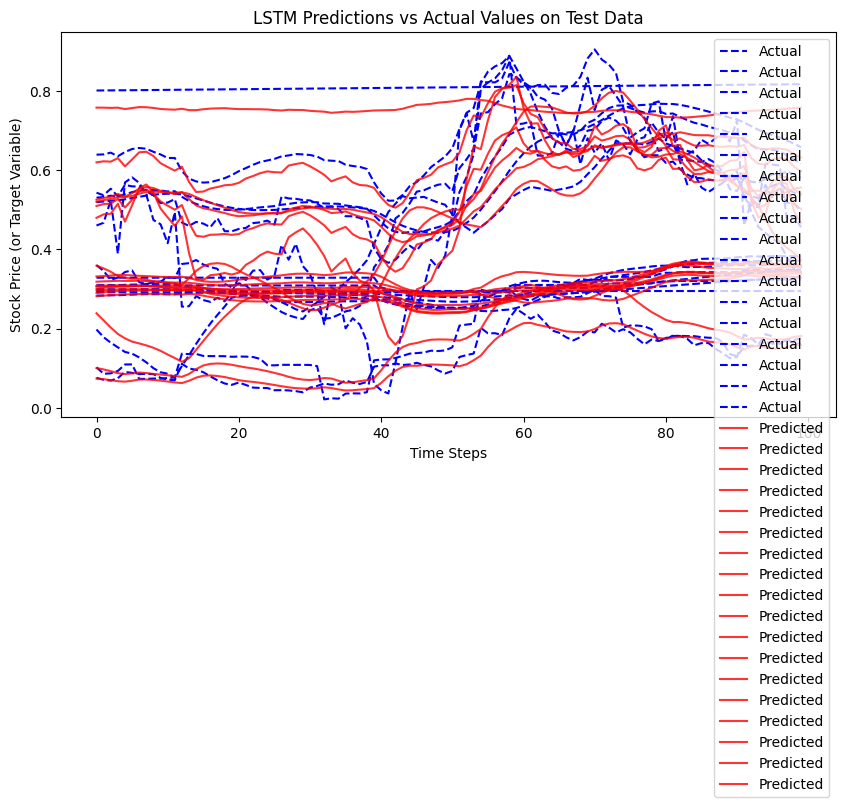

In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in evaluation mode (disables dropout & batch norm)
model.eval()

# Move X_test to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Disable gradient calculations for inference
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Move predictions to CPU
y_pred_numpy = y_pred_tensor.cpu().numpy()

# ✅ Fix: y_test is already NumPy, so no .cpu() needed
y_test_numpy = y_test  # No need for .cpu().numpy()

# 🔹 Compute Evaluation Metrics
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
mae = mean_absolute_error(y_test_numpy, y_pred_numpy)
r2 = r2_score(y_test_numpy, y_pred_numpy)

# Print metrics
print(f"🔹 Test MSE: {mse:.6f}")
print(f"🔹 Test MAE: {mae:.6f}")
print(f"🔹 R² Score: {r2:.4f}")

# 🔹 Plot Actual vs Predicted (First 100 Samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test_numpy[:100], label="Actual", linestyle="dashed", color="blue")
plt.plot(y_pred_numpy[:100], label="Predicted", alpha=0.8, color="red")
plt.legend()
plt.title("LSTM Predictions vs Actual Values on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (or Target Variable)")
plt.show()


### Hyper tuning

In [15]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define LSTM Model
def create_lstm_model(input_dim, hidden_dim, num_layers, dropout, output_dim):
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out[:, -1, :])  # Take the last time step output
    
    return LSTMModel()

# Objective function for Optuna
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    
    model = create_lstm_model(input_dim=X_train.shape[2], hidden_dim=hidden_dim,
                              num_layers=num_layers, dropout=dropout, output_dim=y_train.shape[1])
    model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(10):  # Small epochs for tuning
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    return loss.item()

# Run Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Run 20 trials

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-03-08 21:15:11,861] A new study created in memory with name: no-name-6c6fe4e7-c382-48c6-b388-13ec4f44b524
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5280\3038151413.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[W 2025-03-08 21:15:14,441] Trial 0 failed with parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.30000000000000004, 'batch_size': 64, 'learning_rate': 0.00045762520491143534} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "e:\Python\venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_5280\3038151413.py", line 45, in obje

KeyboardInterrupt: 

## Model with the parameters that came out of the previous testing

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Define Optimized LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim=192, num_layers=2, output_size=17, dropout_prob=0.5):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers=num_layers, dropout=dropout_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take only the last timestep output
        return x

# Instantiate model with optimized hyperparameters
input_size = X_train.shape[2]  # Number of features
output_size = y_train.shape[1]  # Number of target variables
model = LSTMModel(input_size, output_size=output_size).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005839081038527126)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
batch_size = 16  # Optimized batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with progress bar
epochs = 10  # Adjust epochs based on early stopping
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "Best_LSTM_model.pth")
print("✅ Best model saved as 'Best_LSTM_model.pth'")


🔥 Using device: cuda


Epoch 1/10: 100%|██████████| 308/308 [00:04<00:00, 61.76batch/s, loss=0.0030]


✅ Epoch [1/10], Loss: 0.0145, Val Loss: 0.0050


Epoch 2/10: 100%|██████████| 308/308 [00:04<00:00, 65.96batch/s, loss=0.0016]


✅ Epoch [2/10], Loss: 0.0030, Val Loss: 0.0028


Epoch 3/10: 100%|██████████| 308/308 [00:04<00:00, 65.34batch/s, loss=0.0019]


✅ Epoch [3/10], Loss: 0.0021, Val Loss: 0.0019


Epoch 4/10: 100%|██████████| 308/308 [00:04<00:00, 66.22batch/s, loss=0.0008]


✅ Epoch [4/10], Loss: 0.0017, Val Loss: 0.0021


Epoch 5/10: 100%|██████████| 308/308 [00:04<00:00, 66.13batch/s, loss=0.0024]


✅ Epoch [5/10], Loss: 0.0015, Val Loss: 0.0021


Epoch 6/10: 100%|██████████| 308/308 [00:04<00:00, 64.95batch/s, loss=0.0016]


✅ Epoch [6/10], Loss: 0.0014, Val Loss: 0.0021


Epoch 7/10: 100%|██████████| 308/308 [00:04<00:00, 65.13batch/s, loss=0.0006]


✅ Epoch [7/10], Loss: 0.0013, Val Loss: 0.0022


Epoch 8/10: 100%|██████████| 308/308 [00:04<00:00, 62.34batch/s, loss=0.0008]


✅ Epoch [8/10], Loss: 0.0011, Val Loss: 0.0013


Epoch 9/10: 100%|██████████| 308/308 [00:04<00:00, 63.62batch/s, loss=0.0008]


✅ Epoch [9/10], Loss: 0.0011, Val Loss: 0.0020


Epoch 10/10: 100%|██████████| 308/308 [00:04<00:00, 64.59batch/s, loss=0.0013]


✅ Epoch [10/10], Loss: 0.0010, Val Loss: 0.0013
✅ Best model saved as 'Best_LSTM_model.pth'


🔹 Test MSE: 0.001339
🔹 Test MAE: 0.028313
🔹 R² Score: 0.7985


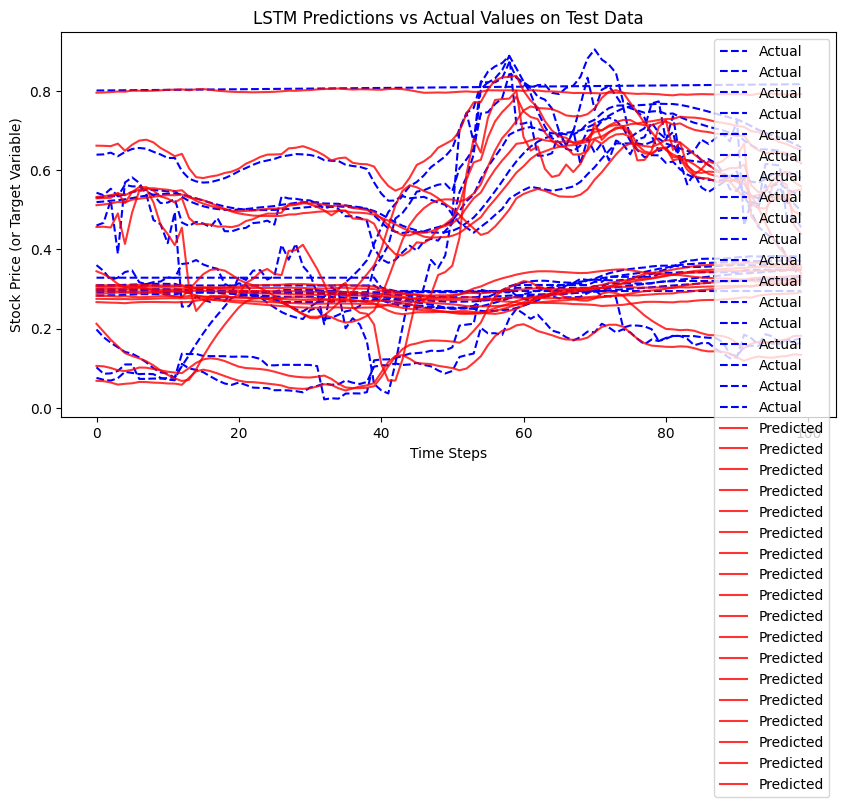

In [17]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure model is in evaluation mode (disables dropout & batch norm)
model.eval()

# Move X_test to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Disable gradient calculations for inference
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Move predictions to CPU
y_pred_numpy = y_pred_tensor.cpu().numpy()

# ✅ Fix: y_test is already NumPy, so no .cpu() needed
y_test_numpy = y_test  # No need for .cpu().numpy()

# 🔹 Compute Evaluation Metrics
mse = mean_squared_error(y_test_numpy, y_pred_numpy)
mae = mean_absolute_error(y_test_numpy, y_pred_numpy)
r2 = r2_score(y_test_numpy, y_pred_numpy)

# Print metrics
print(f"🔹 Test MSE: {mse:.6f}")
print(f"🔹 Test MAE: {mae:.6f}")
print(f"🔹 R² Score: {r2:.4f}")

# 🔹 Plot Actual vs Predicted (First 100 Samples)
plt.figure(figsize=(10, 5))
plt.plot(y_test_numpy[:100], label="Actual", linestyle="dashed", color="blue")
plt.plot(y_pred_numpy[:100], label="Predicted", alpha=0.8, color="red")
plt.legend()
plt.title("LSTM Predictions vs Actual Values on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price (or Target Variable)")
plt.show()


# Feedforward Neural Network (FNN)

### Create the Y because X is already there

In [19]:
from sklearn.model_selection import train_test_split
features = [
        "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
        "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
        "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "seconds"
    ]
df_as_np = df[features].to_numpy()
# Define features (X) and target (y)
X = df_as_np  # Convert feature columns to NumPy array
y_close = df["close"].to_numpy()  # Convert target column to NumPy array

print("X shape:", X.shape)
print("y shape:", y_close.shape)

# Train-test split (80% train, 20% test), preserving time series order
X_train, X_test, signals_train, signals_test = train_test_split(X, y_close, test_size=0.2, random_state=42, shuffle=False)

print("X_train shape:", X_train.shape)
print("y_train shape:", signals_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", signals_test.shape)

import numpy as np



X shape: (6204, 18)
y shape: (6204,)
X_train shape: (4963, 18)
y_train shape: (4963,)
X_test shape: (1241, 18)
y_test shape: (1241,)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # Progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Features and Target
features = [
    "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
    "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
    "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", "seconds"
]
X = df[features].values
y = df["close"].values  # Predicting close price instead of trend

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% train, 20% test, preserving time series order)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Make it 2D
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)  # Make it 2D

# Define Larger Feedforward Neural Network
class PricePredictionNN(nn.Module):
    def __init__(self, input_size):
        super(PricePredictionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)  # Single output for regression
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
input_size = len(features)
model = PricePredictionNN(input_size).to(device)

# Loss and Optimizer (Using Mean Squared Error for regression)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Lower LR for stable training

# Create DataLoader for mini-batch training
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "LARGE_FNN_price_model.pth")
print("✅ Model saved as 'LARGE_FNN_price_model.pth'")

# Function to Predict Future Prices
def predict_price(model, X_new):
    model.eval()
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(X_new_tensor)
    return predictions.cpu().numpy()

# Example usage
predicted_prices = predict_price(model, X_test)
print("Sample Predictions:", predicted_prices[:10])
print("Sample Actual Prices:", y_test[:10])


🔥 Using device: cuda


Epoch 1/30: 100%|██████████| 78/78 [00:00<00:00, 106.24batch/s, loss=0.0559]


✅ Epoch [1/30], Loss: 0.0741, Val Loss: 0.0102


Epoch 2/30: 100%|██████████| 78/78 [00:00<00:00, 161.07batch/s, loss=0.0298]


✅ Epoch [2/30], Loss: 0.0310, Val Loss: 0.0044


Epoch 3/30: 100%|██████████| 78/78 [00:00<00:00, 163.85batch/s, loss=0.0370]


✅ Epoch [3/30], Loss: 0.0182, Val Loss: 0.0016


Epoch 4/30: 100%|██████████| 78/78 [00:00<00:00, 167.18batch/s, loss=0.0121]


✅ Epoch [4/30], Loss: 0.0134, Val Loss: 0.0019


Epoch 5/30: 100%|██████████| 78/78 [00:00<00:00, 150.30batch/s, loss=0.0123]


✅ Epoch [5/30], Loss: 0.0097, Val Loss: 0.0016


Epoch 6/30: 100%|██████████| 78/78 [00:00<00:00, 161.40batch/s, loss=0.0200]


✅ Epoch [6/30], Loss: 0.0083, Val Loss: 0.0007


Epoch 7/30: 100%|██████████| 78/78 [00:00<00:00, 167.43batch/s, loss=0.0079]


✅ Epoch [7/30], Loss: 0.0075, Val Loss: 0.0026


Epoch 8/30: 100%|██████████| 78/78 [00:00<00:00, 162.28batch/s, loss=0.0092]


✅ Epoch [8/30], Loss: 0.0063, Val Loss: 0.0004


Epoch 9/30: 100%|██████████| 78/78 [00:00<00:00, 151.10batch/s, loss=0.0213]


✅ Epoch [9/30], Loss: 0.0061, Val Loss: 0.0017


Epoch 10/30: 100%|██████████| 78/78 [00:00<00:00, 149.33batch/s, loss=0.0033]


✅ Epoch [10/30], Loss: 0.0056, Val Loss: 0.0012


Epoch 11/30: 100%|██████████| 78/78 [00:00<00:00, 162.26batch/s, loss=0.0059]


✅ Epoch [11/30], Loss: 0.0053, Val Loss: 0.0013


Epoch 12/30: 100%|██████████| 78/78 [00:00<00:00, 146.16batch/s, loss=0.0138]


✅ Epoch [12/30], Loss: 0.0060, Val Loss: 0.0009


Epoch 13/30: 100%|██████████| 78/78 [00:00<00:00, 154.88batch/s, loss=0.0088]


✅ Epoch [13/30], Loss: 0.0050, Val Loss: 0.0006


Epoch 14/30: 100%|██████████| 78/78 [00:00<00:00, 162.82batch/s, loss=0.0020]


✅ Epoch [14/30], Loss: 0.0051, Val Loss: 0.0011


Epoch 15/30: 100%|██████████| 78/78 [00:00<00:00, 159.02batch/s, loss=0.0088]


✅ Epoch [15/30], Loss: 0.0045, Val Loss: 0.0010


Epoch 16/30: 100%|██████████| 78/78 [00:00<00:00, 151.88batch/s, loss=0.0052]


✅ Epoch [16/30], Loss: 0.0047, Val Loss: 0.0009


Epoch 17/30: 100%|██████████| 78/78 [00:00<00:00, 160.96batch/s, loss=0.0024]


✅ Epoch [17/30], Loss: 0.0041, Val Loss: 0.0009


Epoch 18/30: 100%|██████████| 78/78 [00:00<00:00, 160.71batch/s, loss=0.0036]


✅ Epoch [18/30], Loss: 0.0053, Val Loss: 0.0002


Epoch 19/30: 100%|██████████| 78/78 [00:00<00:00, 160.58batch/s, loss=0.0036]


✅ Epoch [19/30], Loss: 0.0043, Val Loss: 0.0006


Epoch 20/30: 100%|██████████| 78/78 [00:00<00:00, 148.10batch/s, loss=0.0049]


✅ Epoch [20/30], Loss: 0.0043, Val Loss: 0.0005


Epoch 21/30: 100%|██████████| 78/78 [00:00<00:00, 168.35batch/s, loss=0.0128]


✅ Epoch [21/30], Loss: 0.0046, Val Loss: 0.0002


Epoch 22/30: 100%|██████████| 78/78 [00:00<00:00, 166.31batch/s, loss=0.0033]


✅ Epoch [22/30], Loss: 0.0045, Val Loss: 0.0008


Epoch 23/30: 100%|██████████| 78/78 [00:00<00:00, 166.76batch/s, loss=0.0103]


✅ Epoch [23/30], Loss: 0.0042, Val Loss: 0.0003


Epoch 24/30: 100%|██████████| 78/78 [00:00<00:00, 145.10batch/s, loss=0.0023]


✅ Epoch [24/30], Loss: 0.0040, Val Loss: 0.0005


Epoch 25/30: 100%|██████████| 78/78 [00:00<00:00, 162.75batch/s, loss=0.0046]


✅ Epoch [25/30], Loss: 0.0040, Val Loss: 0.0005


Epoch 26/30: 100%|██████████| 78/78 [00:00<00:00, 146.52batch/s, loss=0.0092]


✅ Epoch [26/30], Loss: 0.0041, Val Loss: 0.0012


Epoch 27/30: 100%|██████████| 78/78 [00:00<00:00, 161.54batch/s, loss=0.0030]


✅ Epoch [27/30], Loss: 0.0033, Val Loss: 0.0004


Epoch 28/30: 100%|██████████| 78/78 [00:00<00:00, 133.52batch/s, loss=0.0024]


✅ Epoch [28/30], Loss: 0.0040, Val Loss: 0.0005


Epoch 29/30: 100%|██████████| 78/78 [00:00<00:00, 151.27batch/s, loss=0.0019]


✅ Epoch [29/30], Loss: 0.0035, Val Loss: 0.0009


Epoch 30/30: 100%|██████████| 78/78 [00:00<00:00, 162.27batch/s, loss=0.0134]


✅ Epoch [30/30], Loss: 0.0043, Val Loss: 0.0012
✅ Model saved as 'LARGE_FNN_price_model.pth'
Sample Predictions: [[0.2581463 ]
 [0.2575842 ]
 [0.25911292]
 [0.26069152]
 [0.2589311 ]
 [0.262437  ]
 [0.26214767]
 [0.2652538 ]
 [0.26340437]
 [0.26286104]]
Sample Actual Prices: [0.28797365 0.28709774 0.288036   0.28978159 0.28927973 0.29130899
 0.29111884 0.29600184 0.29339124 0.29404895]


In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# ✅ Remove noisy features (e.g., 'seconds')
features = [
    "EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
    "ATR", "MACD", "MACD_signal", "MACD_hist", "ROC", "ADX", 
    "DC_upper", "DC_lower", "DC_middle", "Volume_SMA", "Volatility", 
    "open", "high", "low", "close"
]

X = df[features].values
y = df["signals"].values  # Target (1 = Uptrend, 0 = Downtrend)

# ✅ Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

# ✅ Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# ✅ Compute Class Weights (Better Balance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ✅ Use Swish Activation (Better than ReLU)
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# ✅ Better Feedforward Neural Network
class AdvancedFNN(nn.Module):
    def __init__(self, input_size):
        super(AdvancedFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            Swish(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            Swish(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            Swish(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            Swish(),
            nn.Dropout(0.1),

            nn.Linear(32, 1)  # No Sigmoid (Handled by BCEWithLogitsLoss)
        )

    def forward(self, x):
        return self.model(x)

# ✅ Instantiate model
input_size = len(features)
model = AdvancedFNN(input_size).to(device)

# ✅ Focal Loss (Better for Class Imbalance)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        focal_weight = self.alpha * (1 - probs) ** self.gamma
        return focal_weight * bce_loss

criterion = FocalLoss()

# ✅ Optimizer + Learning Rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

# ✅ Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Training loop with LR scheduling
epochs = 40  # More epochs for better learning
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for batch_X, batch_y in progress_bar:
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_X)
        loss = criterion(logits, batch_y).mean()  # Ensure loss is a scalar
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # ✅ Validation
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test_tensor)
        val_loss = criterion(val_logits, y_test_tensor)

    scheduler.step(val_loss.item())  # Convert tensor to scalar
    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}")

# ✅ Save Model
torch.save(model.state_dict(), "AdvancedFNN_price_trend.pth")
print("✅ Model saved as 'AdvancedFNN_price_trend.pth'")

# ✅ Prediction Function
def predict_trend(model, X_new):
    model.eval()
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(X_new_tensor)
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities > 0.5).int()
    return predictions.cpu().numpy()

# Example usage
predictions = predict_trend(model, X_test)
print("Sample Predictions:", predictions[:10])


e:\Python\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔥 Using device: cuda


Epoch 1/40: 100%|██████████| 78/78 [00:00<00:00, 128.93batch/s, loss=0.0198]


RuntimeError: a Tensor with 1241 elements cannot be converted to Scalar

# CPU Codes

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Enable GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ Using GPU:", gpus[0])
    tf.config.experimental.set_memory_growth(gpus[0], True)  # Prevents memory overload
else:
    print("⚠️ No GPU detected, using CPU.")

def build_lstm_model(input_shape, output_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(output_shape, activation="linear"),  # Linear for regression
    ])
    
    model.compile(loss="mse", optimizer="adam")  # No need to add mse as metric (loss is already mse)
    return model

# Build the model
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_shape=y_train.shape[1])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,  # Reduced epochs
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1  # Show cleaner progress
)

# Save the model
model_path = models_dir / "LSTM_FNN_LSTM_model.h5"
model.save(str(model_path))


⚠️ No GPU detected, using CPU.
Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0780 - val_loss: 0.0079
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0150 - val_loss: 0.0049
Epoch 3/50
 81/154 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0103

KeyboardInterrupt: 